# Load all packages

download dataset:
    
    # https://www.kaggle.com/datasets/mohamedchahed/dog-breeds
    
or

directly download in your colab notebook

In [6]:
# !pip install kaggle

In [7]:
# from google.colab import files
# files.upload()

In [8]:
# # Upload Kaggle API Token: then proceed
# # move api token
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [9]:
# # download dataset
# !kaggle datasets download -d 'mohamedchahed/dog-breeds'
# # unzip dataset
# !unzip dog-breeds.zip

In [10]:
import os
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler


# Data Augmentation

In [11]:
# Creating ImageDataGenerator instance to Augument,split and then pass our images to the model
data_gen = ImageDataGenerator(rescale = 1./255 ,
                              width_shift_range = 0.2 ,
                              validation_split=0.1,
                              height_shift_range = 0.2 ,
                              shear_range = 0.2 ,
                              horizontal_flip = True ,
                              vertical_flip = True,
                              zoom_range = 0.2)

# Applying Data Augementation On Both Training and validation sets

In [12]:
# Creating our test and validation data generator to flow images to network from images directory

training_data = data_gen.flow_from_directory('/content/dog-breeds',
                                            target_size = (224,224),
                                            class_mode='categorical',
                                            subset = 'training'
                                            )
validation_data = data_gen.flow_from_directory('/content/dog-breeds',
                                              target_size = (224,224),
                                              class_mode='categorical',
                                              subset = 'validation')

Found 490 images belonging to 8 classes.
Found 51 images belonging to 8 classes.


# Downloading a Pretrained InceptionV3 Model by URL

In [13]:
# Downloading the pre-trained weights.
#No top means it excludes the fully connected layer it uses for classification.We only need convolution layers.
# In Colab or Kaggle Notebook use the following
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O //content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-06-02 07:09:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘//content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

//content/sample_da 100%[===================>]  83.84M   161MB/s    in 0.5s    

2025-06-02 07:09:43 (161 MB/s) - ‘//content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



# Transfer Learning Intialization and Configuration

initializes and configures a pre-trained InceptionV3 model for transfer learning. It loads the InceptionV3 model without the top classification layers (fully connected layers), sets its input shape to (224, 224, 3), and loads the pre-trained weights from a file. Additionally, it freezes the weights of all layers in the pre-trained model to prevent them from being updated during training.

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
# As said before we don't want to re-train model's convolutional layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [15]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


# Model Architecutre

In [16]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                        # This Has Regularization effects
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 122,230,696 (466.27 MB)

 Trainable params: 113,255,432 (432.04 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

# Model Compilation

In [17]:
# define the set of callbacks to be passed to the model during training
# defining our scheduler
def step_decay(epoch):
    # initialize the base initial learning rate, drop factor, and
    # epochs to drop every
    initial_alpha = 0.01
    factor = 0.5
    drop_every_epoch = 5
    # compute learning rate for the current epoch
    alpha = initial_alpha * (factor ** np.floor((1+epoch) / drop_every_epoch))
    # return the learning rate
    return float(alpha)

callbacks = [LearningRateScheduler(step_decay)]

# initialize optimizer and model
print("[INFO] compiling model...")

opt = SGD(learning_rate=0.01,momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

[INFO] compiling model...


# Model Training

In [18]:
# Train the model.
history = model.fit(
            training_data,
            validation_data = validation_data,
            epochs = 20,
            callbacks=callbacks,
            verbose = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1209 - loss: 4.7760 - val_accuracy: 0.2549 - val_loss: 2.0027 - learning_rate: 0.0100
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - accuracy: 0.3192 - loss: 1.7891 - val_accuracy: 0.6275 - val_loss: 1.2384 - learning_rate: 0.0100
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 734ms/step - accuracy: 0.6845 - loss: 0.9893 - val_accuracy: 0.6863 - val_loss: 0.8814 - learning_rate: 0.0100
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 730ms/step - accuracy: 0.7363 - loss: 0.7958 - val_accuracy: 0.7647 - val_loss: 0.6993 - learning_rate: 0.0100
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 779ms/step - accuracy: 0.7563 - loss: 0.6310 - val_accuracy: 0.7647 - val_loss: 0.6525 - learning_rate: 0.0050
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 730ms/step - accuracy: 0.8472 - loss: 0.4469 - val_accuracy: 0.8235 - val_loss: 0.3937 - learning_rate: 0.0050
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 797ms/step - accuracy: 0.8555 - loss: 0.401

# plot the training loss and accuracy

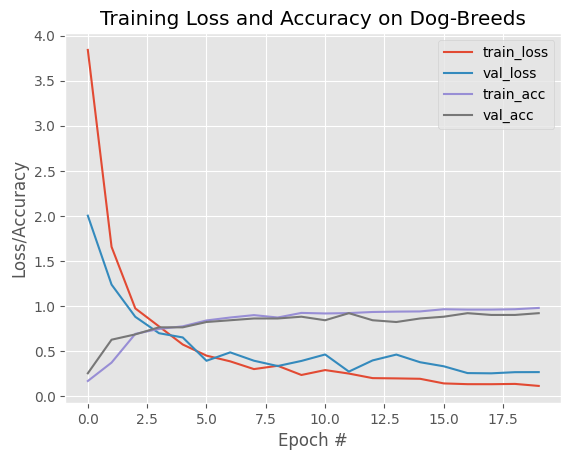

In [19]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dog-Breeds")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


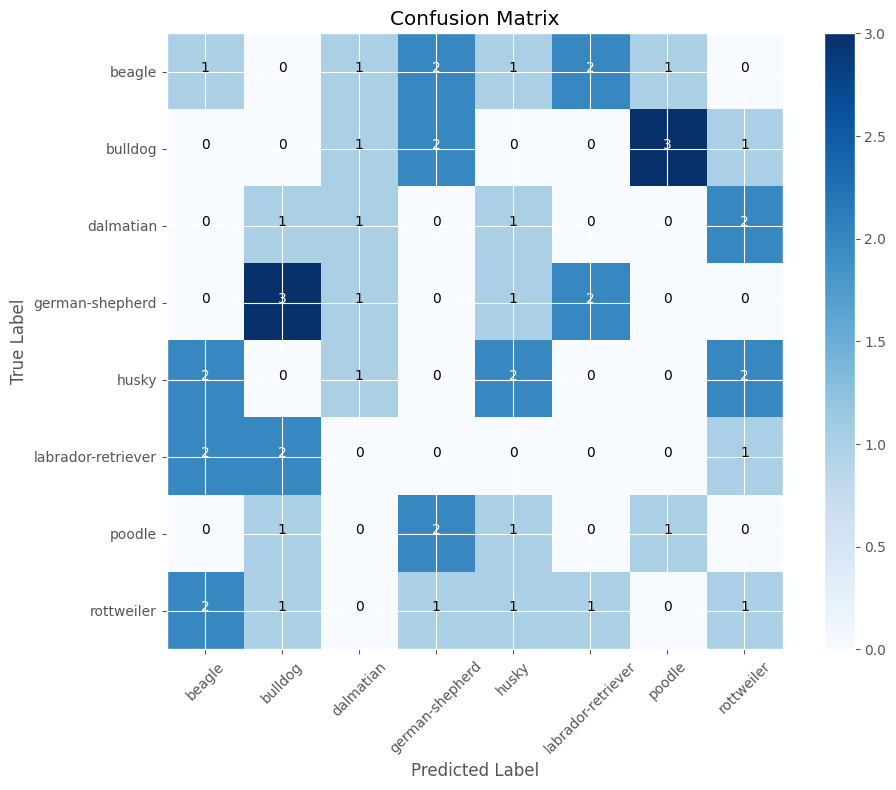

In [20]:
# Generate predictions on the validation set
from sklearn.metrics import confusion_matrix
y_pred = model.predict(validation_data)

# Convert predictions from one-hot encoded format to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels from the validation data generator
true_labels = validation_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add tick marks and labels
tick_marks = np.arange(len(validation_data.class_indices))
plt.xticks(tick_marks, validation_data.class_indices, rotation=45)
plt.yticks(tick_marks, validation_data.class_indices)

# Add text annotations
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Show plot
plt.colorbar()
plt.tight_layout()
plt.show()


# Save and Load Model

In [21]:
#Save the model
model.save('/content/drive/MyDrive/fine_tuned_inception.h5')

In [22]:
# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/fine_tuned_inception.h5')

# Predictive System

In [23]:
from tensorflow.keras.preprocessing import image

def predict_and_display(model, class_labels, img_path, true_class=None):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Make predictions
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence_level = np.max(predictions)

    # Decode the predicted class
    predicted_class_name = class_labels[predicted_class]

    # Display the image
    plt.imshow(img)
    plt.axis('off')

    # Display the predicted class and confidence level
    if true_class:
        plt.title(f'Predicted Class: {predicted_class_name}, True Class: {true_class}')
    else:
        plt.title(f'Predicted Class: {predicted_class_name}')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


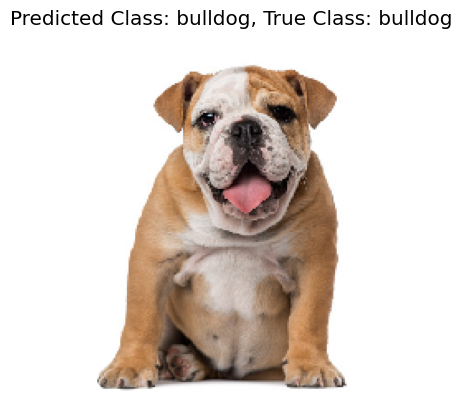

In [24]:
# Assuming you have already defined your model, class labels, and image path
class_labels = ['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']
predict_and_display(model, class_labels, '/content/dog-breeds/bulldog/bulldog108.jpg', true_class='bulldog')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


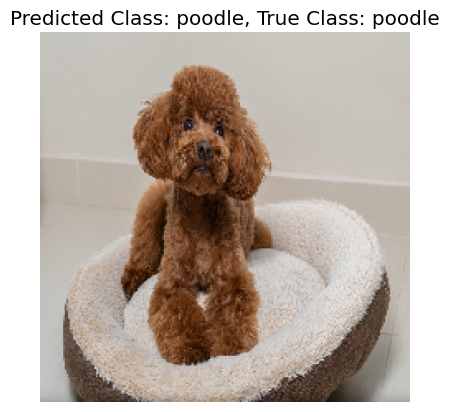

In [25]:
# Assuming you have already defined your model, class labels, and image path
predict_and_display(model, class_labels, '/content/dog-breeds/poodle/poodle116.jpg', true_class="poodle")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


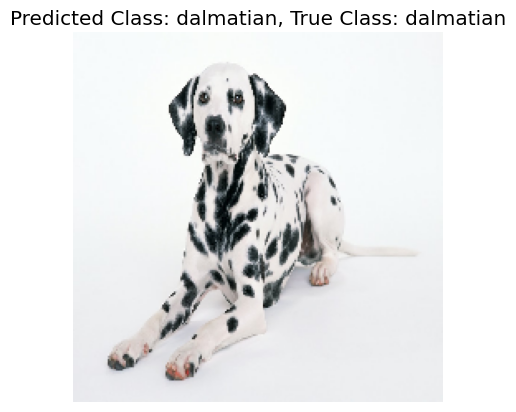

In [26]:
# Assuming you have already defined your model, class labels, and image path
predict_and_display(model, class_labels, '/content/dog-breeds/dalmatian/dalmatian20.jpg', true_class="dalmatian")